# Курсовой проект для курса "Python для Data Science"

Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Материалы к проекту (файлы):
train.csv
test.csv

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

In [220]:
import numpy as np
import pandas as pd
import pickle

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV

warnings.filterwarnings('ignore')
%matplotlib inline
# svg не подключаем, так как система не справляется с таким болшим количеством векторной графики.

In [2]:
TRAIN_DATASET_PATH = 'train.csv'

In [3]:
TEST_DATASET_PATH = 'test.csv'

### Загрузка данных

**Описание датасета:**
* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [4]:
train = pd.read_csv(TRAIN_DATASET_PATH)
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [5]:
test = pd.read_csv(TEST_DATASET_PATH)
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


### Приведение типов данных

### Тренировочный набор

In [6]:
train.shape

(10000, 20)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [8]:
train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

Количество комнат должно быть целым числом.

In [9]:
train['Rooms'].dtype

dtype('float64')

In [10]:
train['Rooms'] = train['Rooms'].astype('int64')

In [11]:
train['Rooms'].dtype

dtype('int64')

Количество этажей целочисленное значение.

In [12]:
train['HouseFloor'].dtype

dtype('float64')

In [13]:
train['HouseFloor'] = train['HouseFloor'].astype('int64')

In [14]:
train['HouseFloor'].dtype

dtype('int64')

Площадь кухни по факту есть целочисленное значение, что ни есть целочисленное значение, то есть выброс.

In [15]:
train['KitchenSquare'].dtype

dtype('float64')

In [16]:
train['KitchenSquare'] = train['KitchenSquare'].astype('int64')

In [17]:
train['KitchenSquare'].dtype

dtype('int64')

### Тестовый набор

In [18]:
test.shape

(5000, 19)

In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       3959 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 742.3+ KB


In [20]:
test.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

Количество комнат должно быть целым числом.

In [21]:
test['Rooms'].dtype

dtype('float64')

In [22]:
test['Rooms'] = test['Rooms'].astype('int64')

In [23]:
test['Rooms'].dtype

dtype('int64')

Количество этажей целочисленное значение.

In [24]:
test['HouseFloor'].dtype

dtype('float64')

In [25]:
test['HouseFloor'] = test['HouseFloor'].astype('int64')

In [26]:
test['HouseFloor'].dtype

dtype('int64')

Площадь кухни по факту есть целочисленное значение, что ни есть целочисленное значение, то есть выброс.

In [27]:
test['KitchenSquare'].dtype

dtype('float64')

In [28]:
test['KitchenSquare'] = test['KitchenSquare'].astype('int64')

In [29]:
test['KitchenSquare'].dtype

dtype('int64')

Объединим оба набора для вычищения данных.

In [30]:
df = pd.concat((train, test), sort=False).reset_index(drop=True)

In [31]:
df.shape

(15000, 20)

### Статистика

In [32]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,15000.000000,15000.000000,15000.000000,15000.000000,11846.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,7825.000000,15000.000000,15000.000000,10000.000000
mean,8393.136933,50.693600,1.897000,56.360350,36.851792,6.174467,8.561800,12.606600,3.321575e+03,0.119196,24.769267,5370.404933,8.113667,1144.162428,1.319467,4.235133,214138.857399
std,4850.111673,43.786257,0.839229,20.423913,71.120183,24.016979,5.323113,6.780165,1.637078e+05,0.119371,17.532278,4013.364403,23.841946,1029.296278,1.489012,4.796545,92872.293865
min,0.000000,0.000000,0.000000,1.136859,0.333490,0.000000,1.000000,0.000000,1.908000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4188.750000,20.000000,1.000000,41.814371,22.896130,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8378.500000,37.000000,2.000000,52.645757,32.822810,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12594.250000,75.000000,2.000000,66.036608,45.144624,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.000000,212.000000,19.000000,641.065193,7480.592129,2014.000000,78.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Обзор количественных переменных

In [33]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])
df_num_features.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,14038,35,2,47.981561,29.442751,6,7,9,1969,0.089040,33,7976,5,NaN,0,11,184966.930730
1,15053,41,3,65.683640,40.049543,8,7,9,1978,0.000070,46,10309,1,240.0,1,16,300009.450063
2,4765,53,2,44.947953,29.197612,0,8,12,1968,0.049637,34,7759,0,229.0,1,3,220925.908524
3,5809,58,2,53.352981,52.731512,9,8,17,1977,0.437885,23,5735,3,1084.0,0,5,175616.227217
4,10783,99,1,39.649192,23.776169,7,11,12,1976,0.012339,35,5776,1,2078.0,2,4,150226.531644


### Обзор номинативных переменных

In [34]:
df_obj_features = df.select_dtypes(include='object')
df_obj_features.head()

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,B


In [35]:
df['Ecology_2'].value_counts()

B    14855
A      145
Name: Ecology_2, dtype: int64

In [36]:
df['Ecology_3'].value_counts()

B    14576
A      424
Name: Ecology_3, dtype: int64

In [37]:
df['Shops_2'].value_counts()

B    13763
A     1237
Name: Shops_2, dtype: int64

### Обработка пропусков

In [38]:
len(df) - df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       3154
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     7175
Helthcare_2         0
Shops_1             0
Shops_2             0
Price            5000
dtype: int64

**LifeSquare**

Поскольку пустых значений слишком много, то рассмотрим их в зависимости от срезов по количеству комнат и по годам и заполним значениями медианы по этим срезам.

In [39]:
df['Rooms'][df['LifeSquare'].isnull()].value_counts()

1    1285
2    1271
3     577
4      15
0       3
5       2
6       1
Name: Rooms, dtype: int64

In [40]:
df['HouseYear'][df['LifeSquare'].isnull()].value_counts()

1977    2757
2016     102
2015      89
2017      87
2014      62
2018      33
2013      11
2019      10
2020       2
2012       1
Name: HouseYear, dtype: int64

In [41]:
for room in df['Rooms'][df['LifeSquare'].isnull()].unique():
    for year in df['HouseYear'][df['LifeSquare'].isnull()].unique():
        df.loc[df['LifeSquare'].isnull() & (df['Rooms'] == room) & (df['HouseYear'] == year), 'LifeSquare'] = df['LifeSquare'][df['LifeSquare'].notnull() & (df['Rooms'] == room) & (df['HouseYear'] == year)].median()

In [42]:
df.loc[df['LifeSquare'].isnull()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3911,770,28,0,49.483501,NaN,0,16,0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
12071,10793,23,6,110.750226,NaN,0,2,2,2015,0.014073,B,B,2,475,0,NaN,0,0,B,NaN


Заполним оставшееся пустое значение в зависимости от среза по площади.

In [43]:
df.loc[df['Id'] == 770, 'LifeSquare'] = df.loc[df['Square'].between(49.0, 50.0), 'Rooms'].median()

In [44]:
df.loc[df['Id'] == 10793, 'LifeSquare'] = df.loc[df['Square'].between(100.0, 120.0), 'Rooms'].median()

**Healthcare_1**

"Раскидаем" пустые значения по имеющимся классам значений

Получим уникальные значения из выборки

In [45]:
values = list(df.loc[df['Healthcare_1'].notnull(), 'Healthcare_1'].unique())

In [46]:
values = sorted(values)

In [47]:
length = len(values)

In [48]:
length

79

In [49]:
values[:5]

[0.0, 30.0, 32.0, 35.0, 46.0]

In [50]:
values[length - 5:]

[4087.0, 4129.0, 4508.0, 4702.0, 4849.0]

In [51]:
b = df.loc[df['Healthcare_1'].isnull()]

In [52]:
for id in b['Id']:
    df.loc[df['Id'] == id, 'Healthcare_1'] = values[random.randint(0, length - 1)]

**Ecology_2**

In [53]:
df['Ecology_2'].mode()[0]

'B'

In [54]:
df.replace({'Ecology_2': {'-':df['Ecology_2'].mode()[0]}}, inplace=True)

In [55]:
df['Ecology_2'].value_counts()

B    14855
A      145
Name: Ecology_2, dtype: int64

**Ecology_3**

In [56]:
df['Ecology_3'].mode()[0]

'B'

In [57]:
df.replace({'Ecology_3': {'-':df['Ecology_3'].mode()[0]}}, inplace=True)

In [58]:
df['Ecology_3'].value_counts()

B    14576
A      424
Name: Ecology_3, dtype: int64

**Shops_2**

In [59]:
df['Shops_2'].mode()[0]

'B'

In [60]:
df.replace({'Shops_2': {'-':df['Shops_2'].mode()[0]}}, inplace=True)

In [61]:
df['Shops_2'].value_counts()

B    13763
A     1237
Name: Shops_2, dtype: int64

### Обработка выбросов

In [62]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,10000.000000
mean,8393.136933,50.693600,1.897000,56.360350,38.524649,6.174467,8.561800,12.606600,3.321575e+03,0.119196,24.769267,5370.404933,8.113667,1261.357600,1.319467,4.235133,214138.857399
std,4850.111673,43.786257,0.839229,20.423913,63.498418,24.016979,5.323113,6.780165,1.637078e+05,0.119371,17.532278,4013.364403,23.841946,1130.853318,1.489012,4.796545,92872.293865
min,0.000000,0.000000,0.000000,1.136859,0.333490,0.000000,1.000000,0.000000,1.908000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4188.750000,20.000000,1.000000,41.814371,25.611946,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8378.500000,37.000000,2.000000,52.645757,33.768078,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,1015.000000,1.000000,3.000000,192269.644879
75%,12594.250000,75.000000,2.000000,66.036608,49.113026,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,1894.000000,2.000000,6.000000,249135.462171
max,16798.000000,212.000000,19.000000,641.065193,7480.592129,2014.000000,78.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Год застройки (HouseYear)**

In [63]:
df.sort_values(by="HouseYear", inplace=True)

In [64]:
df['HouseYear'].value_counts().head(11)

1977    3950
2016     477
2015     458
2017     449
2014     308
1970     305
1969     272
1972     271
1974     263
1971     262
1973     250
Name: HouseYear, dtype: int64

In [65]:
df['HouseYear'].head()

13253    1908
10002    1909
9317     1910
12691    1910
10064    1911
Name: HouseYear, dtype: int64

In [66]:
df['HouseYear'].tail()

790          2020
14389        2020
4376         2020
4189         4968
1497     20052011
Name: HouseYear, dtype: int64

Последние два значения сильно выпадают из общей выборки, предположим, что оператор ошибся.

In [67]:
df.replace({'HouseYear': {4968:1968}}, inplace=True)

In [68]:
df.replace({'HouseYear': {20052011:2005}}, inplace=True)

In [69]:
df.sort_values(by="HouseYear", inplace=True)

In [70]:
df['HouseYear'].tail(5)

585      2020
10385    2020
6735     2020
14273    2020
918      2020
Name: HouseYear, dtype: int64

In [71]:
target_mean = round(df['HouseYear'].mean(), 2)
target_median = df['HouseYear'].median()
target_mode = df['HouseYear'].mode()[0]

target_mean, target_median, target_mode

(1984.71, 1977.0, 1977)

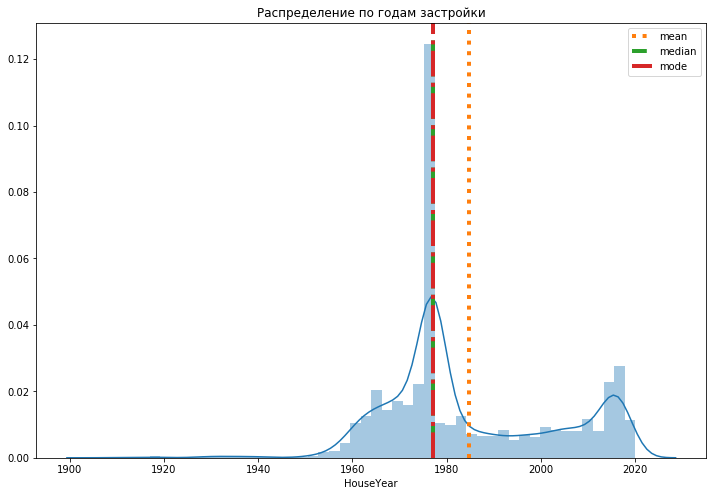

In [72]:
plt.figure(figsize = (12, 8))
sns.distplot(df.loc[df['HouseYear'].notnull(), 'HouseYear'])

y = np.linspace(0, 1, 100)
plt.plot([target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 100, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Распределение по годам застройки')
plt.legend()
plt.show()

Из графика видно, что очень сильный выброс приходится на 1977 год.

In [73]:
id_list = list(df['Id'][df['HouseYear'] == 1977].unique())

In [74]:
for id in id_list:
    house_floor = list(df['HouseFloor'][df['Id'] == id])[0]
    square = round(list(df['Square'][df['Id'] == id])[0])
    result = df['HouseYear'][(df['HouseYear'] != 1977) & (df['HouseFloor'] == house_floor) & (round(df['Square']) == square)].median()
    if pd.notnull(result):
        df.loc[df['Id'] == id, 'HouseYear'] = int(result)

In [75]:
target_mean = round(df['HouseYear'].mean())
target_median = round(df['HouseYear'].median())
target_mode = round(df['HouseYear'].mode()[0])

target_mean, target_median, target_mode

(1991, 1992, 2015)

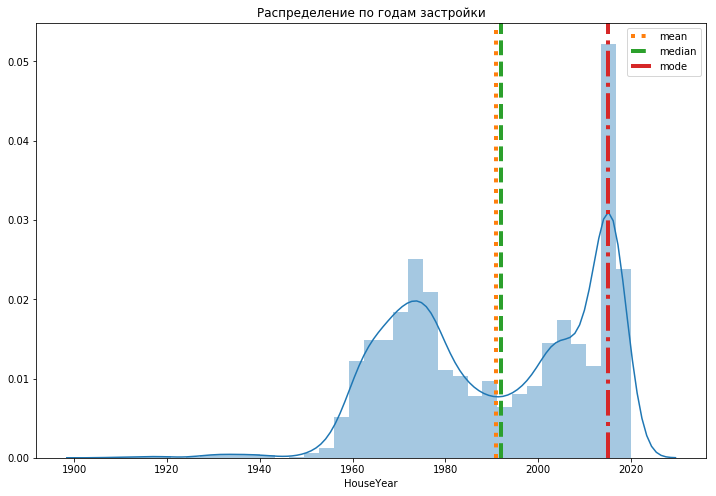

In [76]:
plt.figure(figsize = (12, 8))
sns.distplot(df.loc[df['HouseYear'].notnull(), 'HouseYear'])

y = np.linspace(0, 1, 100)
plt.plot([target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 100, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Распределение по годам застройки')
plt.legend()
plt.show()

**Этажность дома (HouseFloor)**

Отсортируем по этажности

In [77]:
df.sort_values(by="HouseFloor", inplace=True)

In [78]:
df['HouseFloor'].head()

12216    0
7031     0
14892    0
14840    0
6778     0
Name: HouseFloor, dtype: int64

In [79]:
df['HouseFloor'].tail()

13909     48
10651     99
8599      99
6131      99
8854     117
Name: HouseFloor, dtype: int64

In [80]:
df['HouseFloor'].value_counts().head(11)

17    3482
9     2113
12    1600
5     1581
14     969
16     811
1      727
25     553
22     536
0      400
24     274
Name: HouseFloor, dtype: int64

Очень много домов с этажностью 0. Есть четыре высотных дома 1977 года постройки, этажность которых превышает 50 этажей. Будем считать это выбросами и заменим их медианными занчениями. Самая "ходовая" этажность: 5, 9, 12, 17 этажей.

In [81]:
df.loc[df['Id'] == 15864, 'HouseFloor'] = 9

In [82]:
df.loc[df['Id'] == 9300, 'HouseFloor'] = 9

In [83]:
df.loc[df['Id'] == 10806, 'HouseFloor'] = 9

In [84]:
df.loc[df['Id'] == 78, 'HouseFloor'] = 17

In [85]:
id_list = list(df['Id'][(df['HouseFloor'] == 0) | (df['HouseFloor'] < df['Floor'])].unique())

In [86]:
for id in id_list:
    house_floor = list(df['HouseFloor'][df['Id'] == id])[0]
    floor = list(df['Floor'][df['Id'] == id])[0]
    year = list(df['HouseYear'][df['Id'] == id])[0]
    
    result = df['HouseFloor'][(df['HouseFloor'] != 0) & (df['HouseYear'] == year) & (df['HouseFloor'] >= floor)].median()
    if pd.notnull(result):
        df.loc[df['Id'] == id, 'HouseFloor'] = int(result)

In [87]:
id_list = list(df['Id'][df['HouseFloor'] < df['Floor']].unique())

In [88]:
for id in id_list:
    df.loc[df['Id'] == id, 'HouseFloor'] = df.loc[df['Id'] == id, 'Floor']

In [89]:
df.loc[df['Id'] == 15759, 'HouseFloor'] = 9

In [90]:
df.loc[df['Id'] == 15759, 'Floor'] = 9

In [91]:
house_floor_target_mean = round(df['HouseFloor'].mean())
house_floor_target_median = round(df['HouseFloor'].median())
house_floor_target_mode = round(df['HouseFloor'].mode()[0])

house_floor_target_mean, house_floor_target_median, house_floor_target_mode

(14, 16, 17)

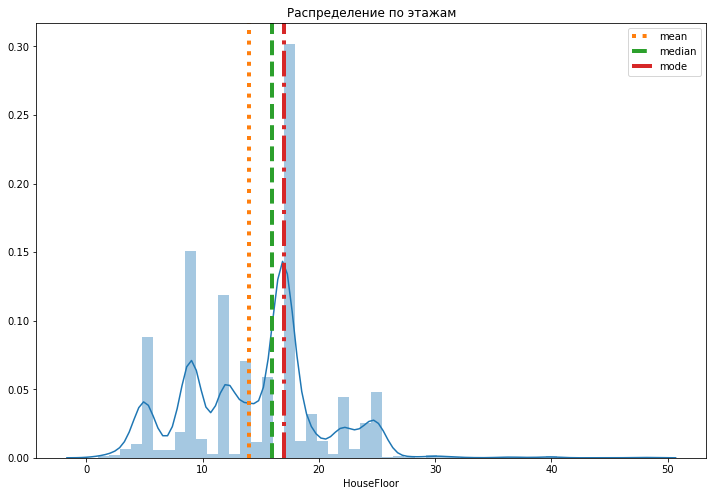

In [92]:
plt.figure(figsize = (12, 8))
sns.distplot(df['HouseFloor'])

y = np.linspace(0, 1, 100)
plt.plot([house_floor_target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([house_floor_target_median] * 100, y, label='median', linestyle='--', linewidth=4)
plt.plot([house_floor_target_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Распределение по этажам')
plt.legend()
plt.show()

**Количество комнат (Rooms)**

In [93]:
df['Rooms'].unique()

array([ 3,  2,  1,  4,  0,  5,  6, 10, 19, 17], dtype=int64)

Очевидно, что 0 комнат нет, а 6, 10 и 19 комнат это какие-то выбросы, проверим и приведем их к нормальному значению по площади.

In [94]:
df.loc[df['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4853,3224,27,0,2.377248,0.873147,0,1,11,1977,0.017647,B,B,2,469,0,730.0,0,0,B,126596.941798
2269,7317,27,0,41.790881,63.973134,0,13,17,2016,0.211401,B,B,9,1892,0,4702.0,0,1,B,98129.976788
12524,10729,27,0,76.345154,42.820796,12,14,19,1977,0.017647,B,B,2,469,0,2078.0,0,0,B,NaN
3911,770,28,0,49.483501,2.000000,0,16,17,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
4366,456,6,0,81.491446,63.973134,0,4,19,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
1981,7917,27,0,212.932361,211.231125,0,2,3,2008,0.211401,B,B,9,1892,0,1046.0,0,1,B,302211.260887
12406,3343,58,0,116.824201,113.692424,0,3,3,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,NaN
1397,12638,27,0,138.427694,136.215499,0,4,17,2016,0.075424,B,B,11,3097,0,1015.0,0,0,B,268394.744389
8834,9443,27,0,87.762616,85.125471,0,5,15,1977,0.211401,B,B,9,1892,0,1894.0,0,1,B,219281.918007
6149,3159,88,0,38.697117,19.345131,9,9,16,1982,0.127376,B,B,43,8429,3,2715.0,3,9,B,158998.110646


In [95]:
df.loc[(df['Rooms'] == 0.0) & (df['Square'] < 45.0), 'Rooms'] = 1

In [96]:
df.loc[(df['Rooms'] == 0.0) & df['Square'].between(45.0, 65.0), 'Rooms'] = 2

In [97]:
df.loc[(df['Rooms'] == 0.0) & df['Square'].between(65.0, 85.0), 'Rooms'] = 3

In [98]:
df.loc[(df['Rooms'] == 0.0) & df['Square'].between(85.0, 105.0), 'Rooms'] = 4

In [99]:
df.loc[(df['Rooms'] == 0.0) & (df['Square'] > 106), 'Rooms'] = 5

In [100]:
df['Rooms'][df['Rooms'] == 0].value_counts()

Series([], Name: Rooms, dtype: int64)

In [101]:
df.loc[df['Rooms'] == 6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
12071,10793,23,6,110.750226,3.000000,0,2,2,2015,0.014073,B,B,2,475,0,2715.0,0,0,B,NaN
13217,4058,27,6,223.453689,104.113552,16,2,2,2017,0.041116,B,B,53,14892,4,1015.0,1,4,B,NaN
2170,14003,99,6,59.414334,38.702244,6,7,9,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416


Площадь маленькая для 6-комнатной квартиры

In [102]:
df.loc[df['Rooms'] == 6, 'Rooms'] = 3

In [103]:
df.loc[df['Rooms'] == 10]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
8849,14865,9,10,60.871266,38.420681,10,3,17,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863
377,5927,57,10,59.056975,36.223072,10,22,22,2002,0.090799,B,B,74,19083,2,1970.0,5,15,B,317265.323792


Аналогично.

In [104]:
df.loc[df['Rooms'] == 10, 'Rooms'] = 3

In [105]:
df['Rooms'][df['Rooms'] == 10].value_counts()

Series([], Name: Rooms, dtype: int64)

In [106]:
df.loc[df['Rooms'] == 19]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1454,8491,1,19,42.006046,21.779288,7,17,17,2014,0.007122,B,B,1,264,0,1815.0,0,1,B,78364.616704


In [107]:
df.loc[df['Rooms'] == 19, 'Rooms'] = 1

In [108]:
df.loc[df['Rooms'] == 17]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
13398,1435,111,17,52.866107,32.528342,8,15,17,1987,0.093443,B,B,23,4635,5,3300.0,2,4,B,NaN


In [109]:
df.loc[df['Rooms'] == 17, 'Rooms'] = 1

In [110]:
df['Rooms'].unique()

array([3, 2, 1, 4, 5], dtype=int64)

**Площадь (Square)**

In [111]:
df.sort_values(by="Square", inplace=True)

In [112]:
# df.loc[(df['Square'] - df['LifeSquare']) <= -df['Square']/4, ['Id', 'Square', 'LifeSquare', "KitchenSquare", 'Rooms', 'HouseYear']]

In [113]:
df.loc[df['Id'] == 16550, 'LifeSquare'] = df.loc[df['Id'] == 16550, 'LifeSquare'] / 100

In [114]:
df.loc[df['Id'] == 15886, 'LifeSquare'] = df.loc[df['Id'] == 15886, 'LifeSquare'] / 10

In [115]:
df.loc[df['Id'] == 11533, 'LifeSquare'] = df.loc[df['Id'] == 11533, 'LifeSquare'] / 10

In [116]:
df.loc[df['Id'] == 14990, 'LifeSquare'] = df.loc[df['Id'] == 14990, 'LifeSquare'] / 10

In [117]:
df.loc[df['Id'] == 8961, 'LifeSquare'] = df.loc[df['Id'] == 8961, 'LifeSquare'] / 10

In [118]:
df.loc[df['Id'] == 1748, 'Square'] = df.loc[df['Id'] == 1748, 'Square'] * 10

In [119]:
df.loc[df['Id'] == 13265, 'Square'] = df.loc[df['Id'] == 13265, 'Square'] * 10

In [120]:
df.loc[df['Id'] == 4504, 'Square'],df.loc[df['Id'] == 4504, 'LifeSquare'] = df.loc[df['Id'] == 4504, 'LifeSquare'] * 10, df.loc[df['Id'] == 4504, 'Square'] * 10

In [121]:
df.loc[df['Id'] == 10527, 'Square'] = df.loc[df['Id'] == 10527, 'Square'] * 10

In [122]:
df.loc[df['Id'] == 6782, 'Square'],df.loc[df['Id'] == 6782, 'LifeSquare'] = df.loc[df['Id'] == 6782, 'LifeSquare'] * 10, df.loc[df['Id'] == 6782, 'Square'] * 10

In [123]:
df.loc[df['Id'] == 170, 'Square'] = df.loc[df['Id'] == 170, 'Square'] * 10

In [124]:
df.loc[df['Id'] == 16401, 'Square'],df.loc[df['Id'] == 16401, 'LifeSquare'] = df.loc[df['Id'] == 16401, 'LifeSquare'] * 10, df.loc[df['Id'] == 16401, 'Square'] * 10

In [125]:
df.loc[df['Id'] == 10202, 'Square'],df.loc[df['Id'] == 10202, 'LifeSquare'] = df.loc[df['Id'] == 10202, 'LifeSquare'] * 10, df.loc[df['Id'] == 10202, 'Square'] * 10

In [126]:
df.loc[df['Id'] == 15744, 'Square'],df.loc[df['Id'] == 15744, 'LifeSquare'] = df.loc[df['Id'] == 15744, 'LifeSquare'] * 10, df.loc[df['Id'] == 15744, 'Square'] * 10

In [127]:
df.loc[df['Id'] == 1420, 'Square'],df.loc[df['Id'] == 1420, 'LifeSquare'] = df.loc[df['Id'] == 1420, 'LifeSquare'] * 10, df.loc[df['Id'] == 1420, 'Square'] * 10

In [128]:
df.loc[df['Id'] == 14786, 'Square'],df.loc[df['Id'] == 14786, 'LifeSquare'] = df.loc[df['Id'] == 14786, 'LifeSquare'] * 10, df.loc[df['Id'] == 14786, 'Square'] * 10

In [129]:
id_list = list(df.loc[(df['Square'] - df['LifeSquare']) < 0, 'Id'])

In [130]:
for id in id_list:
    df.loc[df['Id'] == id, 'Square'],df.loc[df['Id'] == id, 'LifeSquare'] = df.loc[df['Id'] == id, 'LifeSquare'], df.loc[df['Id'] == id, 'Square']

In [131]:
df[['Square', 'LifeSquare', "KitchenSquare", 'Rooms', 'HouseYear']].head(10)

,Square,LifeSquare,KitchenSquare,Rooms,HouseYear
6392,45.257356,11.368588,1,1,1977
10066,1.378543,1.353573,1,1,1977
14902,29.003714,19.757689,1,1,1977
8283,26.422186,19.889427,1,1,1977
14490,2.372101,1.899119,1,1,1977
4853,2.377248,0.873147,0,1,1977
1608,46.049430,25.963512,1,1,2014
10608,43.387555,26.450465,1,1,1977
14713,61.468563,29.005856,1,2,2014
9294,52.572785,29.543086,1,1,1977


In [132]:
id_list = list(df.loc[df['Square'] < 10, 'Id'])

In [133]:
for id in id_list:
    df.loc[df['Id'] == id, 'Square'] = df.loc[df['Id'] == id, 'Square'] * 10
    df.loc[df['Id'] == id, 'LifeSquare'] = df.loc[df['Id'] == id, 'LifeSquare'] * 10

In [134]:
df['Square'][df['HouseYear'] == 1977].quantile(0.75)

86.4915796066495

In [135]:
df.loc[df['Id'] == 11602, 'Square'],df.loc[df['Id'] == 11602, 'LifeSquare'] = df.loc[df['Id'] == 11602, 'Square'] / 10, df.loc[df['Id'] == 11602, 'LifeSquare'] / 10

In [136]:
df.loc[df['Id'] == 28, 'Square'] = df.loc[df['Id'] == 28, 'Square'] / 10

In [137]:
df.loc[df['Id'] == 2307, 'Square'],df.loc[df['Id'] == 2307, 'LifeSquare'] = df.loc[df['Id'] == 2307, 'Square'] / 10, df.loc[df['Id'] == 2307, 'LifeSquare'] / 10

In [138]:
q1 = df['Square'][(df['HouseYear'] == 1977) & (df['Rooms'] == 1)].quantile(0.75)
q1

49.828830093899725

In [139]:
df['Square'][(df['HouseYear'] == 1977) & (df['Rooms'] == 1)].median()

44.602760796266494

In [140]:
q2 = df['Square'][(df['HouseYear'] == 1977) & (df['Rooms'] == 2)].quantile(0.75)
q2

76.31285054725404

In [141]:
df['Square'][(df['HouseYear'] == 1977) & (df['Rooms'] == 2)].median()

66.61793283459605

In [142]:
q3 = df['Square'][(df['HouseYear'] == 1977) & (df['Rooms'] == 3)].quantile(0.75)
q3

106.0765043203753

In [143]:
df['Square'][(df['HouseYear'] == 1977) & (df['Rooms'] == 3)].median()

88.57561085097389

In [144]:
q4 = df['Square'][(df['HouseYear'] == 1977) & (df['Rooms'] == 4)].quantile(0.75)
q4

136.2336667215908

In [145]:
df['Square'][(df['HouseYear'] == 1977) & (df['Rooms'] == 4)].median()

101.97851366957336

In [146]:
q5 = df['Square'][(df['HouseYear'] == 1977) & (df['Rooms'] == 5)].quantile(0.75)
q5

128.70878041096557

In [147]:
df['Square'][(df['HouseYear'] == 1977) & (df['Rooms'] == 5)].median()

121.97634832635842

In [148]:
df.loc[(df['HouseYear'] == 1977) & (df['Rooms'] == 1) & (df['Square'] > q1), 'Square'] = df['Square'][(df['HouseYear'] == 1977) & (df['Rooms'] == 1) & (df['Square'] > q1)].median()

In [149]:
df.loc[(df['HouseYear'] == 1977) & (df['Rooms'] == 2) & (df['Square'] > q2), 'Square'] = df['Square'][(df['HouseYear'] == 1977) & (df['Rooms'] == 2) & (df['Square'] > q2)].median()

In [150]:
df.loc[(df['HouseYear'] == 1977) & (df['Rooms'] == 3) & (df['Square'] > q3), 'Square'] = df['Square'][(df['HouseYear'] == 1977) & (df['Rooms'] == 3) & (df['Square'] > q3)].median()

In [151]:
df.loc[(df['HouseYear'] == 1977) & (df['Rooms'] == 4) & (df['Square'] > q4), 'Square'] = df['Square'][(df['HouseYear'] == 1977) & (df['Rooms'] == 4) & (df['Square'] > q4)].median()

In [152]:
df.loc[(df['HouseYear'] == 1977) & (df['Rooms'] == 5) & (df['Square'] > q5), 'Square'] = df['Square'][(df['HouseYear'] == 1977) & (df['Rooms'] == 5) & (df['Square'] > q5)].median()

In [153]:
df.loc[(df['Square'] - df['LifeSquare']) < 0, ['Id', 'Square', 'LifeSquare', "KitchenSquare", 'Rooms', 'HouseYear']]

,Id,Square,LifeSquare,KitchenSquare,Rooms,HouseYear
3915,7198,79.991643,80.294115,0,2,1977
2183,12692,79.991643,86.036862,1,2,1977
4261,3774,79.991643,84.747663,0,2,1977
5350,5030,79.991643,101.525114,1,2,1977
506,9552,56.589759,105.432181,0,1,1977
12998,1329,56.589759,102.194117,1,1,1977
13328,14341,79.991643,115.553129,12,2,1977
9308,10322,79.991643,125.306808,12,2,1977
3183,542,129.475017,135.164231,0,3,1977
12126,16531,129.475017,136.389391,0,3,1977


In [154]:
df.loc[df['Id'] == 1329, 'LifeSquare'] = df.loc[df['Id'] == 1329, 'LifeSquare'] / 2

In [155]:
df.loc[df['Id'] == 9552, 'LifeSquare'] = df.loc[df['Id'] == 9552, 'LifeSquare'] / 2

In [156]:
df.loc[df['Id'] == 15362, 'LifeSquare'] = df['LifeSquare'][(df['HouseYear'] == 1977) & (df['Rooms'] == 1) & (df['LifeSquare'] < df['LifeSquare'][(df['HouseYear'] == 1977) & (df['Rooms'] == 1)].quantile(0.75))].median()

In [157]:
df.loc[df['Id'] == 7198, 'Square'] =  df['Square'][(df['HouseYear'].between(1970, 1980)) & (df['Rooms'] == 2)].median()

In [158]:
df.loc[df['Id'] == 12692, 'Square'] =  df['Square'][(df['HouseYear'].between(1970, 1980)) & (df['Rooms'] == 2)].median()

In [159]:
df.loc[df['Id'] == 3774, 'Square'] =  df['Square'][(df['HouseYear'].between(1970, 1980)) & (df['Rooms'] == 2)].median()

In [160]:
df.loc[df['Id'] == 5030, 'Square'] =  df['Square'][(df['HouseYear'].between(1970, 1980)) & (df['Rooms'] == 2)].median()

In [161]:
df.loc[df['Id'] == 14341, 'Square'] =  df['Square'][(df['HouseYear'].between(1970, 1980)) & (df['Rooms'] == 2)].median()

In [162]:
df.loc[df['Id'] == 10322, 'Square'] =  df['Square'][(df['HouseYear'].between(1970, 1980)) & (df['Rooms'] == 2)].median()

In [163]:
df.loc[df['Id'] == 7198, 'LifeSquare'] =  df['LifeSquare'][(df['HouseYear'].between(1970, 1980)) & (df['Rooms'] == 2)].median()

In [164]:
df.loc[df['Id'] == 12692, 'LifeSquare'] =  df['LifeSquare'][(df['HouseYear'].between(1970, 1980)) & (df['Rooms'] == 2)].median()

In [165]:
df.loc[df['Id'] == 3774, 'LifeSquare'] =  df['LifeSquare'][(df['HouseYear'].between(1970, 1980)) & (df['Rooms'] == 2)].median()

In [166]:
df.loc[df['Id'] == 5030, 'LifeSquare'] =  df['LifeSquare'][(df['HouseYear'].between(1970, 1980)) & (df['Rooms'] == 2)].median()

In [167]:
df.loc[df['Id'] == 14341, 'LifeSquare'] =  df['LifeSquare'][(df['HouseYear'].between(1970, 1980)) & (df['Rooms'] == 2)].median()

In [168]:
df.loc[df['Id'] == 10322, 'LifeSquare'] =  df['LifeSquare'][(df['HouseYear'].between(1970, 1980)) & (df['Rooms'] == 2)].median()

In [169]:
df.loc[df['Id'] == 5621, 'Square'] =  df['Square'][(df['HouseYear'].between(1970, 1980)) & (df['Rooms'] == 3)].median()

In [170]:
df.loc[df['Id'] == 16531, 'Square'] =  df['Square'][(df['HouseYear'].between(1970, 1980)) & (df['Rooms'] == 3)].median()

In [171]:
df.loc[df['Id'] == 542, 'Square'] =  df['Square'][(df['HouseYear'].between(1970, 1980)) & (df['Rooms'] == 3)].median()

In [172]:
df.loc[df['Id'] == 3267, 'Square'] =  df['Square'][(df['HouseYear'].between(1970, 1980)) & (df['Rooms'] == 3)].median()

In [173]:
df.loc[df['Id'] == 2603, 'Square'] =  df['Square'][(df['HouseYear'].between(1970, 1980)) & (df['Rooms'] == 3)].median()

In [174]:
df.loc[df['Id'] == 5621, 'LifeSquare'] =  df['LifeSquare'][(df['HouseYear'].between(1970, 1980)) & (df['Rooms'] == 3)].median()

In [175]:
df.loc[df['Id'] == 16531, 'LifeSquare'] =  df['LifeSquare'][(df['HouseYear'].between(1970, 1980)) & (df['Rooms'] == 3)].median()

In [176]:
df.loc[df['Id'] == 542, 'LifeSquare'] =  df['LifeSquare'][(df['HouseYear'].between(1970, 1980)) & (df['Rooms'] == 3)].median()

In [177]:
df.loc[df['Id'] == 3267, 'LifeSquare'] =  df['LifeSquare'][(df['HouseYear'].between(1970, 1980)) & (df['Rooms'] == 3)].median()

In [178]:
df.loc[df['Id'] == 2603, 'LifeSquare'] =  df['LifeSquare'][(df['HouseYear'].between(1970, 1980)) & (df['Rooms'] == 3)].median()

In [179]:
df.sort_values(by="Square", inplace=True)

In [180]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
13697,15435,21,1,13.305531,9.495367,0,6,9,1965,0.194489,B,B,47,8004,3,125.0,3,5,B,NaN
10066,9011,53,1,13.785426,13.535731,1,1,1,1977,0.049637,B,B,34,7759,0,229.0,1,3,B,NaN
10002,5480,190,1,15.948246,13.597819,12,2,5,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B,NaN
4739,12676,81,3,15.988889,13.784865,7,4,5,1960,0.319809,B,B,25,4756,16,2857.0,5,8,B,78388.806186
7767,6927,21,1,16.117154,8.822988,0,2,5,1965,0.194489,B,B,47,8004,3,125.0,3,5,B,79913.267856


In [181]:
# df.tail(60)

In [182]:
# df.loc[(df['Square'] - df['LifeSquare']) > df['LifeSquare'], ['Id', 'Square', 'LifeSquare', "KitchenSquare", 'Rooms', 'HouseYear']]

In [183]:
# df.loc[df['Square'].between(129, 130), ['Id', 'Square', 'LifeSquare', "KitchenSquare", 'Rooms', 'HouseYear']]

In [184]:
df.loc[df['Square'].between(129, 130) & (df['HouseYear'] == 1977), 'Square'] = 56

In [185]:
square_target_mean = round(df['Square'].mean())
square_target_median = round(df['Square'].median())
square_target_mode = round(df['Square'].mode()[0])
square_target_mean, square_target_median, square_target_mode

(56, 53, 54.0)

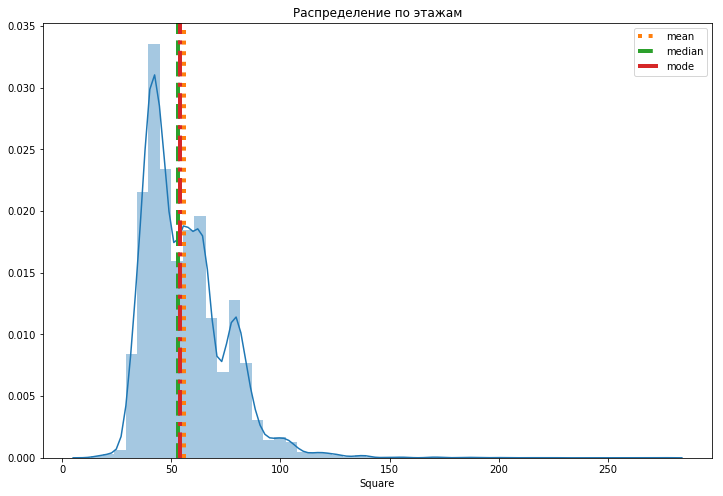

In [186]:
plt.figure(figsize = (12, 8))
sns.distplot(df['Square'])

y = np.linspace(0, 1, 100)
plt.plot([square_target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([square_target_median] * 100, y, label='median', linestyle='--', linewidth=4)
plt.plot([square_target_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Распределение по этажам')
plt.legend()
plt.show()

In [187]:
life_square_target_mean = round(df['LifeSquare'].mean())
life_square_target_median = round(df['LifeSquare'].median())
life_square_target_mode = round(df['LifeSquare'].mode()[0])
life_square_target_mean, life_square_target_median, life_square_target_mode

(38, 34, 31.0)

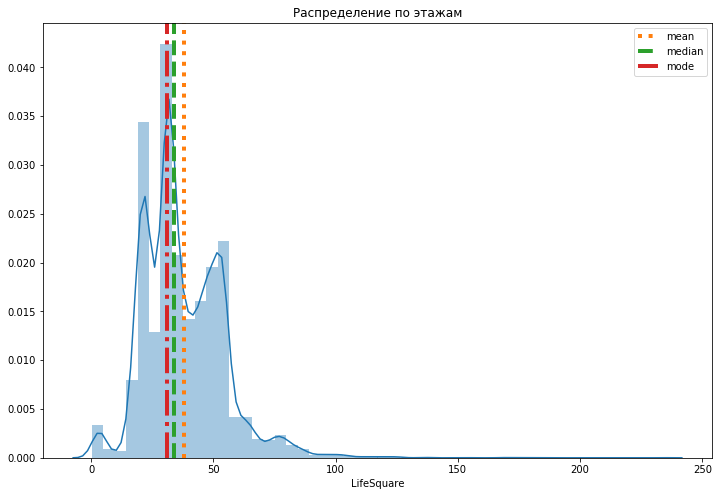

In [188]:
plt.figure(figsize = (12, 8))
sns.distplot(df['LifeSquare'])

y = np.linspace(0, 1, 100)
plt.plot([life_square_target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([life_square_target_median] * 100, y, label='median', linestyle='--', linewidth=4)
plt.plot([life_square_target_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Распределение по этажам')
plt.legend()
plt.show()

In [189]:
kitchen_square_target_mean = round(df['KitchenSquare'].mean())
kitchen_square_target_median = round(df['KitchenSquare'].median())
kitchen_square_target_mode = round(df['KitchenSquare'].mode()[0])
kitchen_square_target_mean, kitchen_square_target_median, kitchen_square_target_mode

(6, 6, 1)

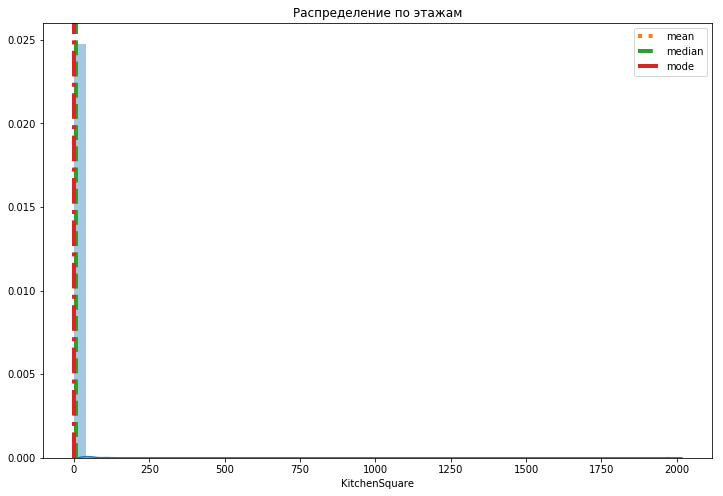

In [190]:
plt.figure(figsize = (12, 8))
sns.distplot(df['KitchenSquare'])

y = np.linspace(0, 1, 100)
plt.plot([kitchen_square_target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([kitchen_square_target_median] * 100, y, label='median', linestyle='--', linewidth=4)
plt.plot([kitchen_square_target_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Распределение по этажам')
plt.legend()
plt.show()

### Отбор и построение новых признаков

In [191]:
df.sort_values(by="Id", inplace=True)

In [192]:
df = pd.concat([df, pd.get_dummies(df['Ecology_2'], prefix='Ecology_2')], axis=1)

In [193]:
df = pd.concat([df, pd.get_dummies(df['Ecology_3'], prefix='Ecology_3')], axis=1)

In [194]:
df = pd.concat([df, pd.get_dummies(df['Shops_2'], prefix='Shops_2')], axis=1)

In [195]:
df.drop(['Id'],axis=1,inplace=True)

In [196]:
df.drop(['Ecology_2'],axis=1,inplace=True)

In [197]:
df.drop(['Ecology_3'],axis=1,inplace=True)

In [198]:
df.drop(['Shops_2'],axis=1,inplace=True)

In [199]:
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
7885,0,1,109.144492,84.613939,15,6,15,2011,0.319809,25,...,2857.0,5,8,289034.391871,0,1,0,1,0,1
14422,1,2,83.830248,83.061098,0,10,22,1996,0.007122,1,...,80.0,0,1,NaN,0,1,0,1,0,1
5549,2,1,34.472263,16.069376,5,5,18,1969,0.000000,33,...,145.0,2,5,174548.966339,0,1,0,1,0,1
10979,3,1,30.185483,14.810573,6,4,9,1970,0.265089,37,...,1937.0,3,2,NaN,0,1,0,1,0,1
14157,4,1,37.294669,17.165597,8,9,9,1970,0.327018,12,...,2500.0,1,0,NaN,0,1,0,1,0,1


Разобъем обратно набор данных df на 2 набора: тренировочный м икчирвый.

In [200]:
df_train = df.loc[df['Price'].notnull()]

In [201]:
df_test = df.loc[df['Price'].isnull()]

Сохраним эти наборы.

In [202]:
DF_TRAIN_DATASET_PATH = 'df_train.csv'

In [203]:
DF_TEST_DATASET_PATH = 'df_test.csv'

In [204]:
df_train.to_csv(DF_TRAIN_DATASET_PATH, index=False, encoding='utf-8')

In [205]:
df_test.to_csv(DF_TEST_DATASET_PATH, index=False, encoding='utf-8')

### Анализ целевой переменной

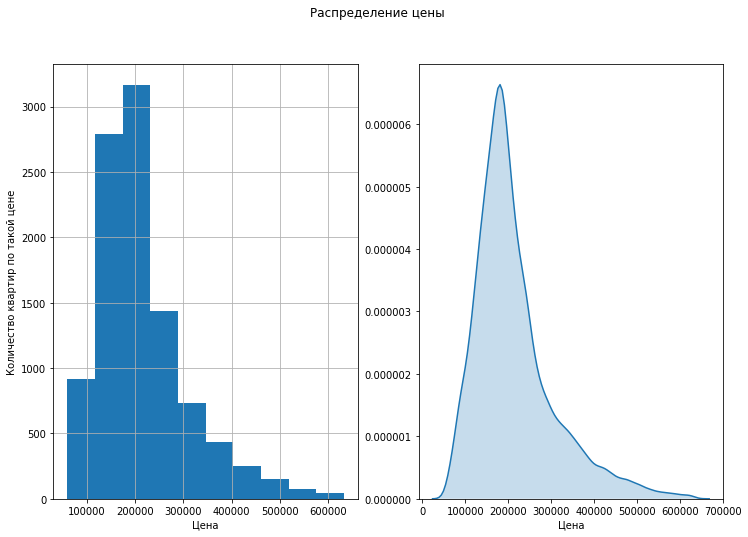

In [206]:
plt.figure(figsize = (12, 8))

plt.subplot(121)
df_train['Price'].hist()
plt.ylabel('Количество квартир по такой цене')
plt.xlabel('Цена')

plt.subplot(122)
sns.kdeplot(df_train['Price'], shade=True, legend=False)
plt.xlabel('Цена')

plt.suptitle('Распределение цены')
plt.show()

Почти идеальное нормальное распределение.

In [207]:
target_mean = round(df_train['Price'].mean(), 2)
target_median = df_train['Price'].median()
target_mode = df_train['Price'].mode()[0]

target_mean, target_median, target_mode

(214138.86, 192269.64487934904, 59174.77802758122)

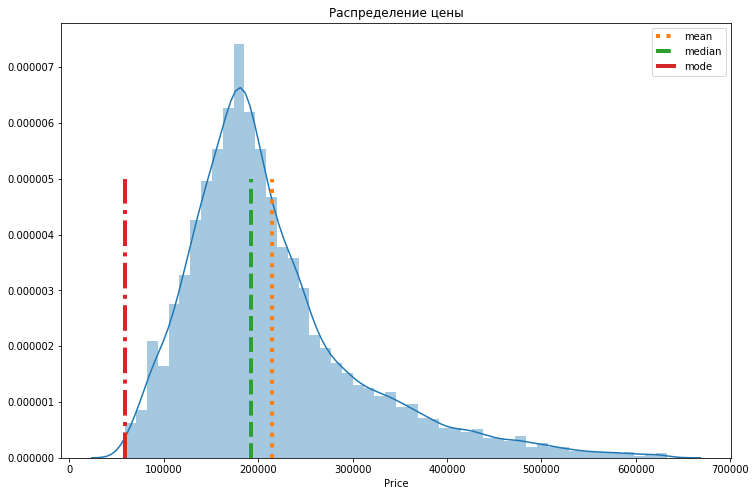

In [208]:
plt.figure(figsize = (12, 8))

sns.distplot(df_train['Price'])

y = np.linspace(0, 0.000005, 100)
plt.plot([target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 100, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Распределение цены')
plt.legend()
plt.show()

### Анализ признаков

In [209]:
df_num_features = df_train.select_dtypes(include=['float64', 'int64'])

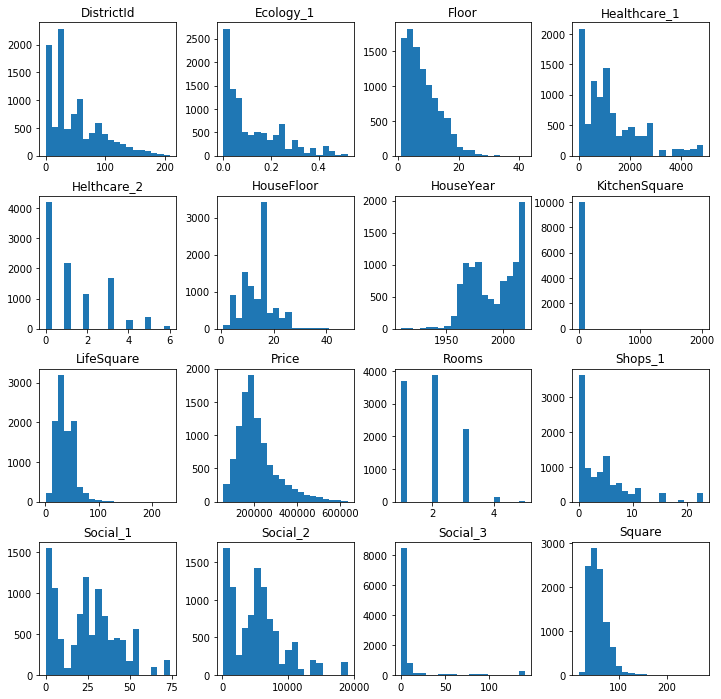

In [210]:
df_num_features.hist(figsize=(12,12), bins=20, grid=False);

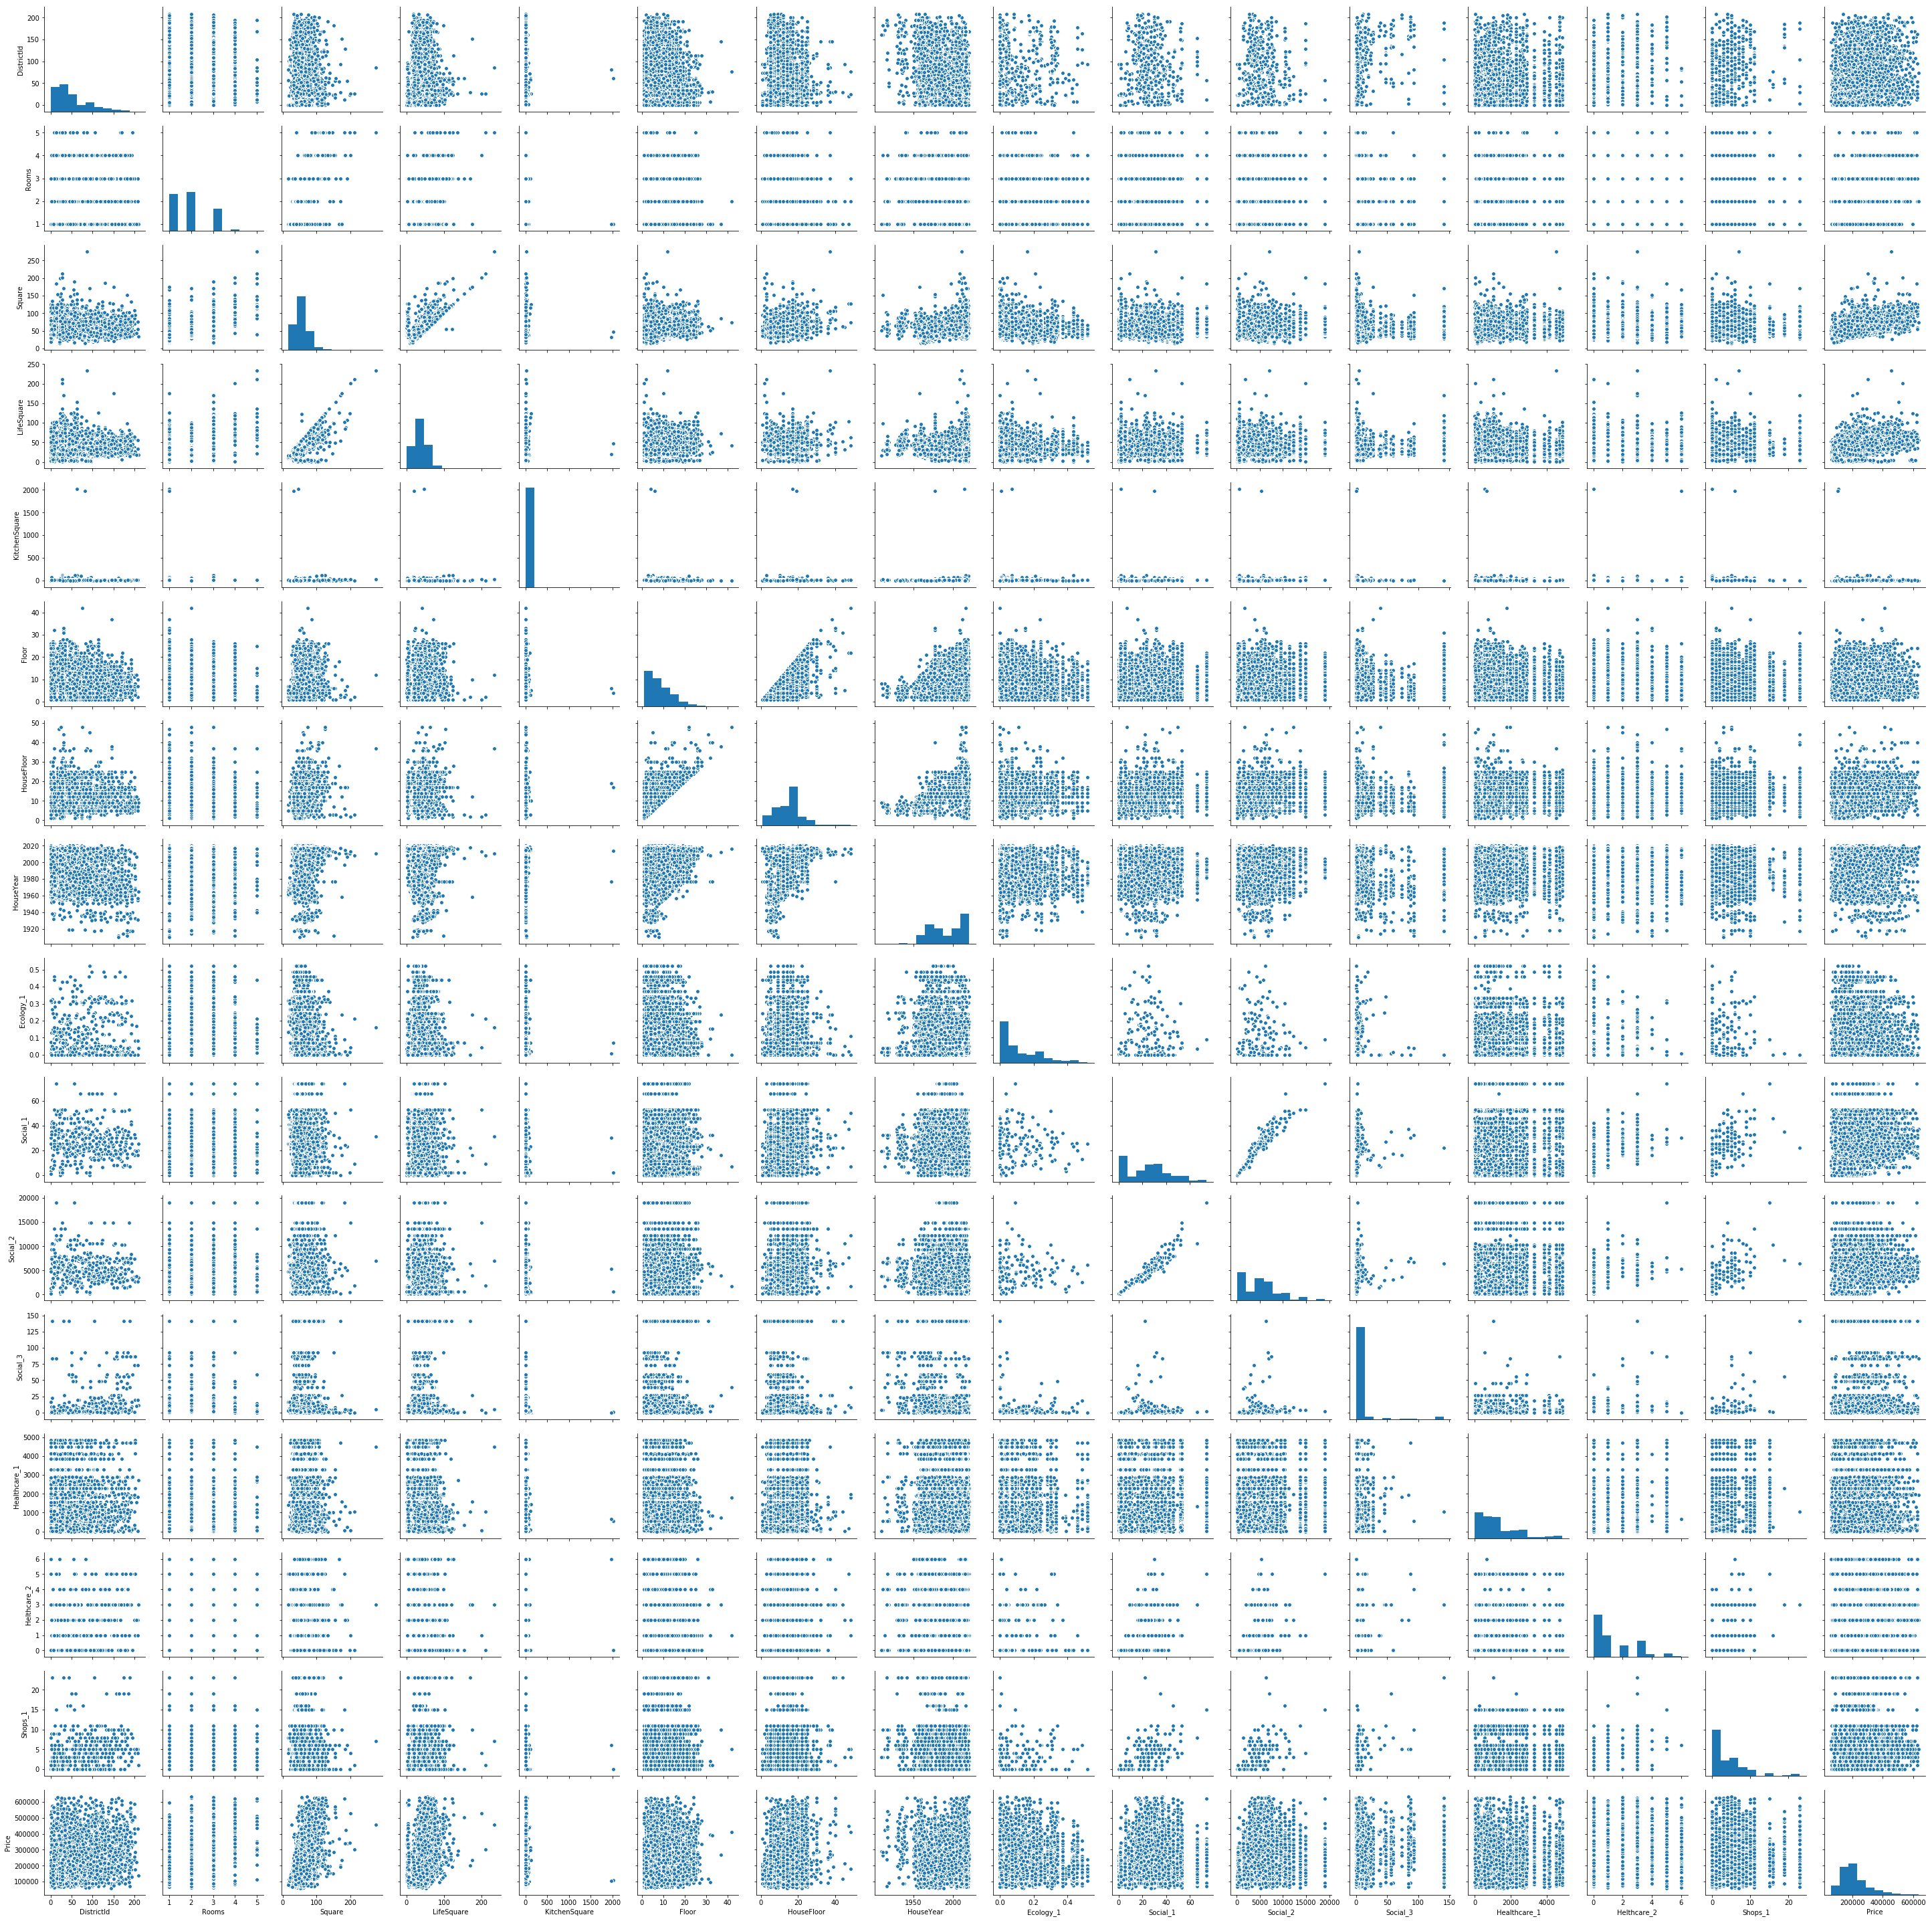

In [211]:
sns.pairplot(df_num_features);

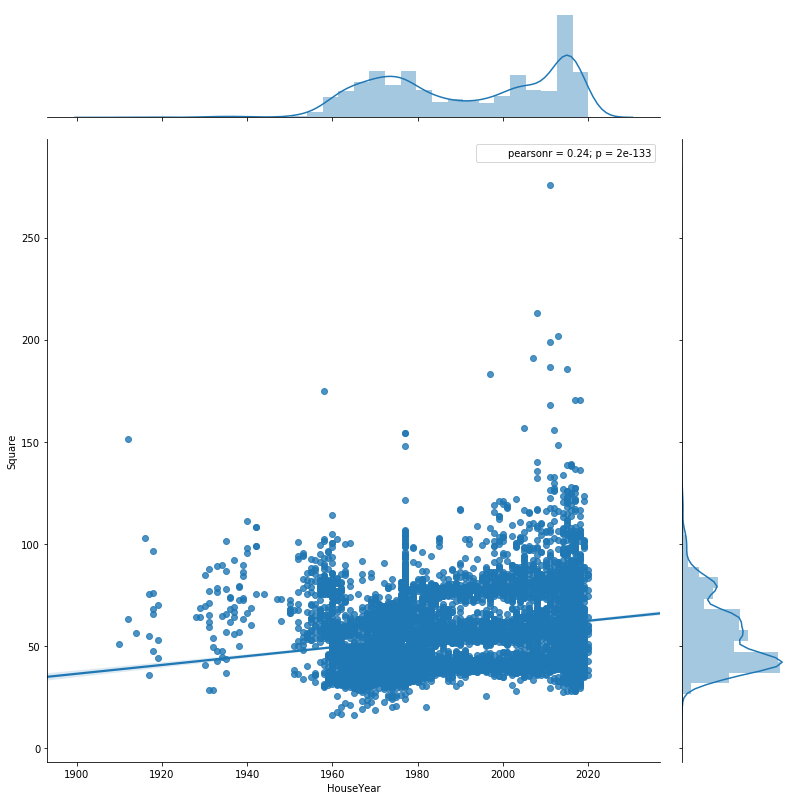

In [213]:
grid = sns.jointplot(df_num_features['HouseYear'], df_num_features['Square'], kind='reg')
grid.fig.set_figwidth(12)
grid.fig.set_figheight(12)

plt.show()

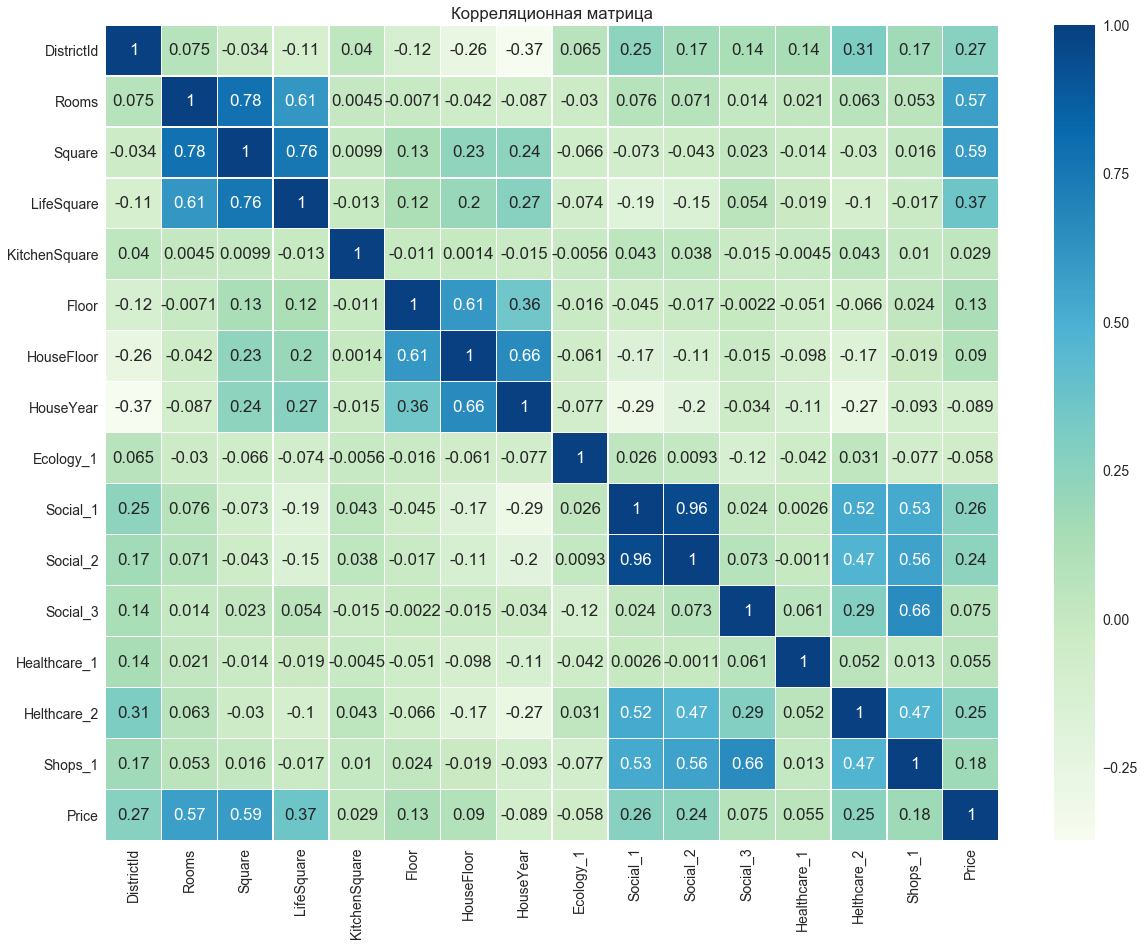

In [214]:
plt.figure(figsize = (20,15))

sns.set(font_scale=1.4)
sns.heatmap(df_num_features.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Корреляционная матрица')
plt.show()

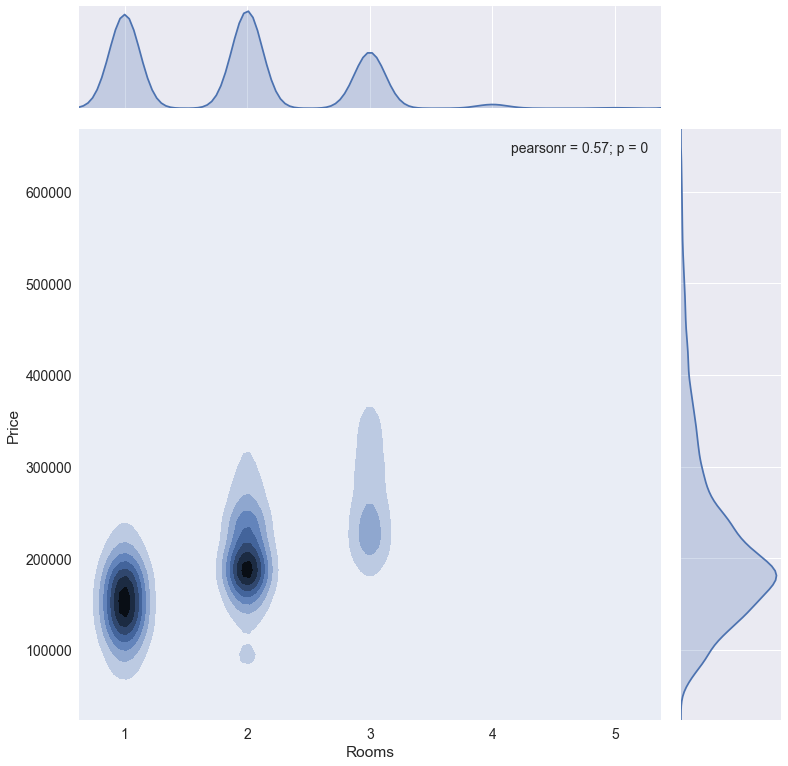

In [215]:
grid = sns.jointplot(df['Rooms'], df['Price'], kind='kde')
grid.fig.set_figwidth(12)
grid.fig.set_figheight(12)

plt.show()

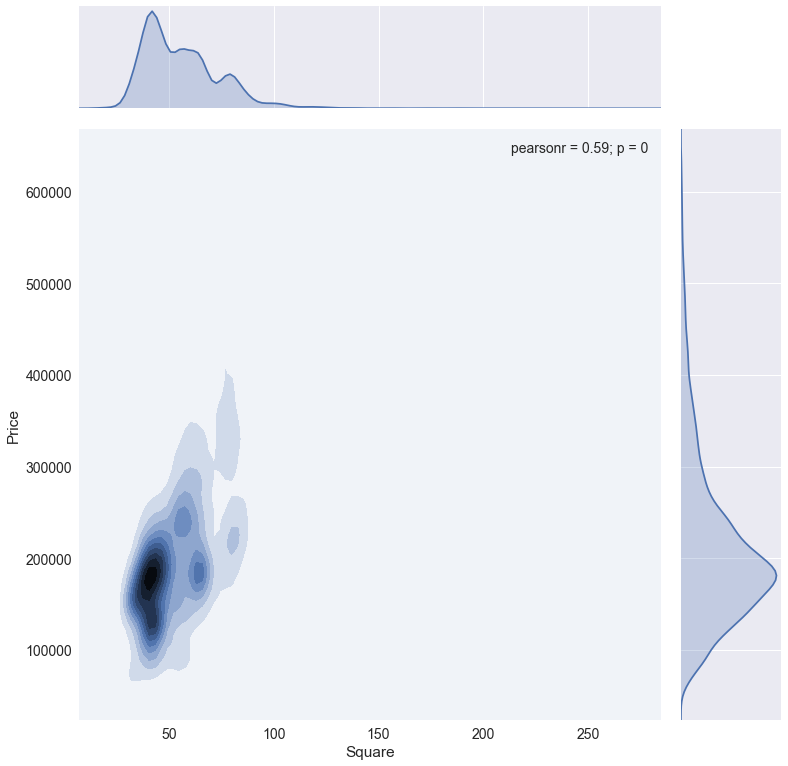

In [216]:
grid = sns.jointplot(df['Square'], df['Price'], kind='kde')
grid.fig.set_figwidth(12)
grid.fig.set_figheight(12)

plt.show()

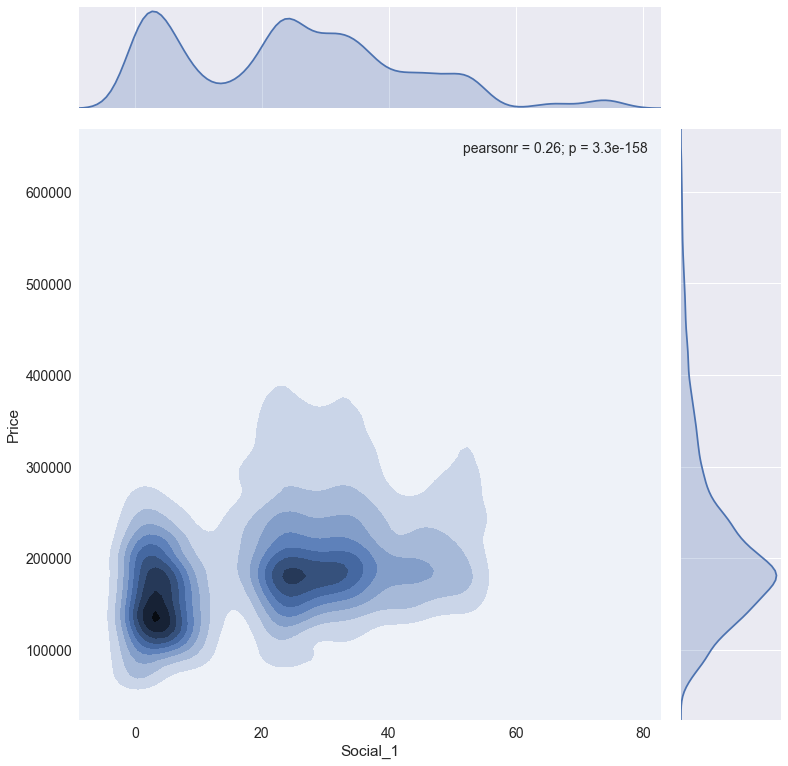

In [217]:
grid = sns.jointplot(df['Social_1'], df['Price'], kind='kde')
grid.fig.set_figwidth(12)
grid.fig.set_figheight(12)

plt.show()

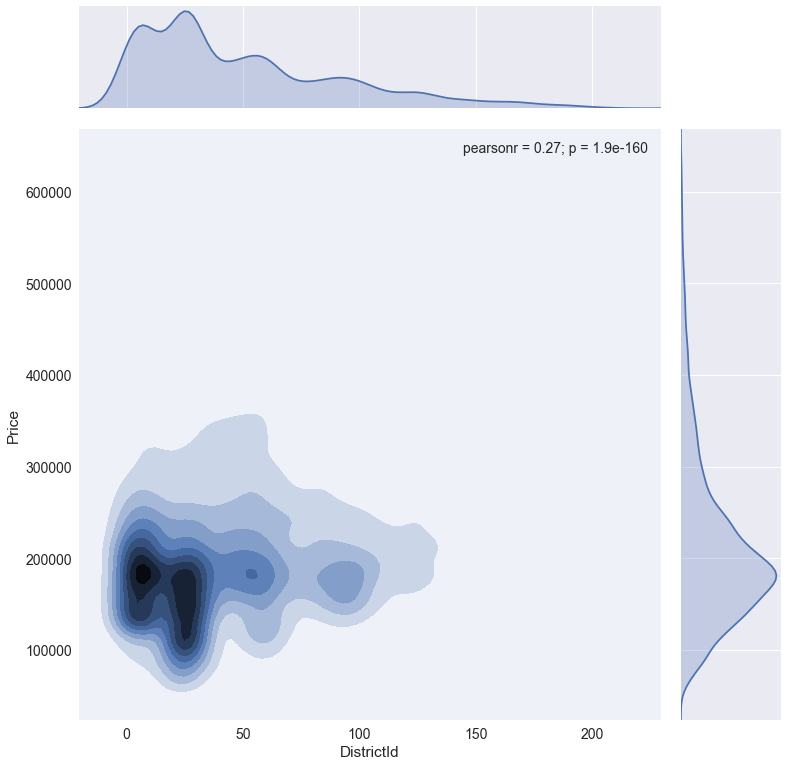

In [218]:
grid = sns.jointplot(df['DistrictId'], df['Price'], kind='kde')
grid.fig.set_figwidth(12)
grid.fig.set_figheight(12)

plt.show()

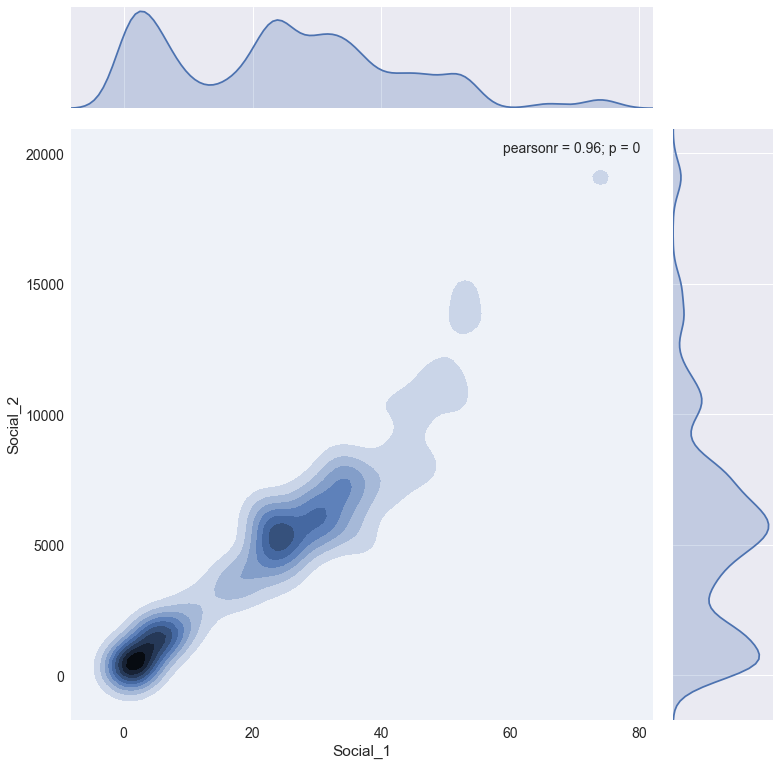

In [219]:
grid = sns.jointplot(df['Social_1'], df['Social_2'], kind='kde')
grid.fig.set_figwidth(12)
grid.fig.set_figheight(12)

plt.show()

### Отбор признаков

In [221]:
df_train.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B']